<a href="https://colab.research.google.com/github/p4triko/Microtransaction-Prediction-IDS25/blob/main/Project_B10_Predict_Microtransaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of microtransaction purchase probability based on gaming habits

The goal of this notebook is to find correlations in the given data and try to predict as accurately as possible, who is more prone to spending money on microtransactions or ingame purchases.

### Initial imports

In [1]:
# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for model training
from sklearn.model_selection import train_test_split

### Loading in the dataset, two options are available. Chooose ONE: either the GitHub URL, if that fails, upload the data manually by downloading the csv file from the repository.

In [2]:

url = 'https://raw.githubusercontent.com/p4triko/Microtransaction-Prediction-IDS25/refs/heads/main/online_gaming_behavior_dataset.csv'

try:
  df = pd.read_csv(url)
  print("Data loaded from GitHub")
except Exception as e:
  print("Github loading failed: ", e)
  print("Trying manual upload")
  from google.colab import files
  uploaded = files.upload()
  name = list(uploaded.keys())[0]
  df = pd.read_csv(name)
  print(f"Loaded data from the file: {name}")

Data loaded from GitHub


### Initial inspections, ensure everything was properly loaded

In [3]:
df.shape

(40034, 13)

In [4]:
df.head(10)

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
5,9005,37,Male,Europe,RPG,20.561855,0,Easy,2,81,74,22,Low
6,9006,25,Male,USA,Action,9.752716,0,Hard,1,50,13,2,Low
7,9007,25,Female,Asia,RPG,4.401729,0,Medium,10,48,27,23,Medium
8,9008,38,Female,Europe,Simulation,18.152733,0,Easy,5,101,23,41,Medium
9,9009,38,Female,Other,Sports,23.942772,0,Easy,13,95,99,36,High


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

### Before cleaning let's check the target distribution and assign a target value.

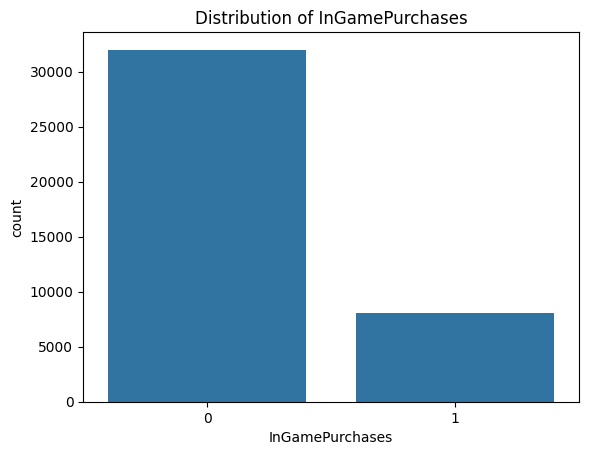

In [6]:
target_column = "InGamePurchases"
df[target_column].value_counts(normalize=True)
sns.countplot(x=target_column, data=df)
plt.title(f"Distribution of {target_column}")
plt.show()

### Data cleaning and preparation

In [7]:
# Drop PlayerID column, as it offers no predictive value.
if 'PlayerID' in df.columns:
  df = df.drop(columns=["PlayerID"])

# Convert AvgSessionDurationMinutes to hours for better interpretability
if 'AvgSessionDurationMinutes' in df.columns:
  df['AvgSessionDurationHours'] = df['AvgSessionDurationMinutes'] / 60
  df = df.drop(columns=["AvgSessionDurationMinutes"])

# Let's check if there are any missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Age                        0
Gender                     0
Location                   0
GameGenre                  0
PlayTimeHours              0
InGamePurchases            0
GameDifficulty             0
SessionsPerWeek            0
PlayerLevel                0
AchievementsUnlocked       0
EngagementLevel            0
AvgSessionDurationHours    0
dtype: int64


### Now we get rid of illogical values

In [8]:
# SessionsPerWeek should be at least 1.
# PlayTimeHours is more realistic, shouldn't be almost 24 hours.
if "SessionsPerWeek" in df.columns:
  before = len(df)
  df = df[df["SessionsPerWeek"] >= 1]
  print(f"SessionsPerWeek cleaned, {before - len(df)} rows with a value of 0.")

if "PlayTimeHours" in df.columns:
  before = len(df)
  df = df[df["PlayTimeHours"] <= 15]
  print(f"PlayTimeHours cleaned, {before - len(df)} rows with an unrealistic playtime.")

SessionsPerWeek cleaned, 1967 rows with a value of 0.
PlayTimeHours cleaned, 14322 rows with an unrealistic playtime.


### Check target distribution after cleaning

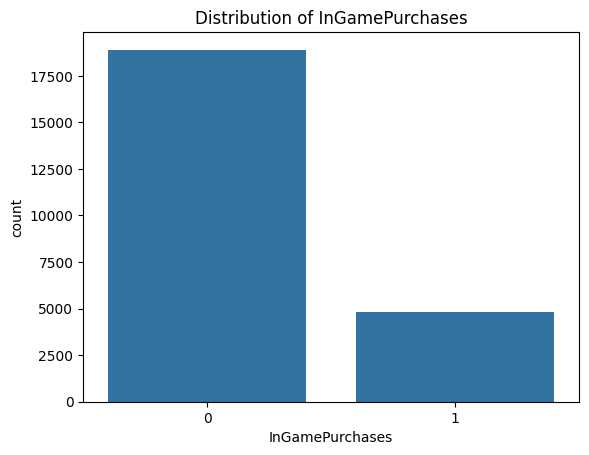

In [9]:
df[target_column].value_counts(normalize=True)
sns.countplot(x=target_column, data=df)
plt.title(f"Distribution of {target_column}")
plt.show()

## Identify and Encode Categorical Features

Our dataset contains quite many categorical features, so we need to identify them in the DataFrame and apply one-hot encoding to convert them into a
numerical format suitable for machine learning models. The original categorical columns will be dropped.


In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical columns identified: {list(categorical_cols)}")

# Apply one-hot encoding and drop original columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("DataFrame after one-hot encoding:")
print(df.head())

Categorical columns identified: ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']
DataFrame after one-hot encoding:
   Age  PlayTimeHours  InGamePurchases  SessionsPerWeek  PlayerLevel  \
1   29       5.525961                0                5           11   
2   22       8.223755                0               16           35   
3   35       5.265351                1                9           57   
6   25       9.752716                0                1           13   
7   25       4.401729                0               10           27   

   AchievementsUnlocked  AvgSessionDurationHours  Gender_Male  \
1                    10                 2.400000        False   
2                    41                 2.366667        False   
3                    47                 1.416667         True   
6                     2                 0.833333         True   
7                    23                 0.800000        False   

   Location_Europe  Location_Other  L

Now we need to change the boolean values into either 1's or 0's for the machine learning algorithms.

In [11]:
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

print("DataFrame after converting boolean columns to 0s and 1s:")
df.head(15)

DataFrame after converting boolean columns to 0s and 1s:


,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,PlayerLevel,AchievementsUnlocked,AvgSessionDurationHours,Gender_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,EngagementLevel_Low,EngagementLevel_Medium
1,29,5.525961,0,5,11,10,2.400000,0,0,0,1,0,0,0,1,0,1,0,1
2,22,8.223755,0,16,35,41,2.366667,0,0,0,1,0,0,1,0,0,0,0,0
3,35,5.265351,1,9,57,47,1.416667,1,0,0,1,0,0,0,0,0,0,0,1
6,25,9.752716,0,1,13,2,0.833333,1,0,0,1,0,0,0,0,1,0,1,0
7,25,4.401729,0,10,27,23,0.800000,0,0,0,0,1,0,0,0,0,1,0,1
10,17,4.829916,0,8,14,12,1.583333,1,0,0,1,0,0,0,1,1,0,0,0
11,36,5.535981,1,16,62,31,2.066667,0,0,0,0,0,1,0,0,0,0,0,0
15,16,7.951511,0,10,58,24,2.600000,1,1,0,0,1,0,0,0,0,1,0,0
20,39,1.722581,0,2,34,37,2.950000,0,0,0,1,0,0,1,0,0,0,0,1
22,42,10.448126,0,2,81,5,2.000000,1,0,0,1,0,0,1,0,0,1,1,0


##Next we seperate the target column from the features and split the data into training and testing sets.

In [12]:
# Separate features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"y_train distribution before undersampling:\n{y_train.value_counts(normalize=True)}")

Shape of X: (23745, 18)
Shape of y: (23745,)
y_train distribution before undersampling:
InGamePurchases
0    0.79601
1    0.20399
Name: proportion, dtype: float64


# Imbalance in the target value

Right now we face an issue that the target value is very unbalanced, almost a
80/20 ratio, meaning one class is significantly more represented than the other. <br>
<br>
The possible solutions are:

*   Undersampling: Reduces the number of samples in the majority class to balance the dataset. This can result in a loss of insight, but since we have so many entries in the target column, it can work.
*   Oversampling: We can use a technique like SMOTE(Synthetic Minority Over-sampling Technique), which creates new synthetic observations of the minority class.

But before that lets apply and try out methods on the original data.

## Creating a function to evaluate and save the results of models
This function is just a helper method, to quickly evaluate given functions and save their data.

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

results = []   # store all models here


def evaluate_model(name, model, X_train, y_train, X_test, y_test, threshold=None):

    # If threshold is None:
    # use model.predict(X_test)  (normal behaviour, threshold = 0.5)
    # If threshold is given (e.g. 0.3):
    # use model.predict_proba(X_test) and apply the custom threshold
    # on the probability of class 1.

    # Train
    model.fit(X_train, y_train)

    # Predictions
    if threshold is None:
        # standard 0.5 threshold inside predict()
        y_pred = model.predict(X_test)
        thr_value = 0.5
    else:
        # manual threshold on P(class=1)
        if not hasattr(model, "predict_proba"):
            raise ValueError("Model does not support predict_proba, cannot use custom threshold.")
        proba_1 = model.predict_proba(X_test)[:, 1]
        y_pred = (proba_1 >= threshold).astype(int)
        thr_value = float(threshold)

    # Per-class metrics
    prec0, rec0, f10, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[0], average=None
    )
    prec1, rec1, f11, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average=None
    )

    # Convert to plain floats
    prec0 = float(prec0[0])
    rec0  = float(rec0[0])
    f10   = float(f10[0])

    prec1 = float(prec1[0])
    rec1  = float(rec1[0])
    f11   = float(f11[0])

    # Macro F1
    macro_f1 = (f10 + f11) / 2

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Save summary results (now also store threshold)
    results.append({
        "Model": name,
        "Threshold": thr_value,
        "Accuracy": acc,
        "Precision_0": prec0,
        "Recall_0": rec0,
        "F1_0": f10,
        "Precision_1": prec1,
        "Recall_1": rec1,
        "F1_1": f11,
        "Macro_F1": macro_f1
    })

    # Print nicely
    print(f"\n=== {name} Results (threshold = {thr_value:.2f}) ===")
    print(f"Accuracy: {acc:.4f}\n")
    print("Class 0 (majority):")
    print(f"  Precision: {prec0:.4f}")
    print(f"  Recall:    {rec0:.4f}")
    print(f"  F1-score:  {f10:.4f}\n")
    print("Class 1 (minority):")
    print(f"  Precision: {prec1:.4f}")
    print(f"  Recall:    {rec1:.4f}")
    print(f"  F1-score:  {f11:.4f}\n")
    print(f"Macro F1: {macro_f1:.4f}")

## Balanced Random Forest

###Using a Balanced Random Forest is a good first attempt, not because it's perfect, but because it solves several imbalance problems automatically and safely.
Using a **Balanced Random Forest** is a good first attempt, not because it's perfect, but because it solves several imbalance problems automatically and safely.

We use the balanced version of the Random Forest to avoid our decision trees becoming biased towards the majority class. Since our dataset is split around 80/20, the splits will mostly optimize for class 0 (not buying microtransactions) and leave class 1 (buying microtransactions) very weak.  
Balanced RF solves this issue by selecting all of the minority samples and an equal amount of randomly chosen majority samples for each tree.

We keep the hyperparameters simple and focused on controlling model complexity:

- **`n_estimators = 300`**  
  We use many trees so that individual random variations average out. This makes the predictions more stable, especially for the minority class.

- **`max_depth = 10`**  
  We limit the depth of each tree so they cannot perfectly memorize the training data. This helps avoid overfitting and forces the model to learn patterns that generalise better to new players.

- **`min_samples_leaf = 10`**  
  Each leaf must contain at least 10 training samples. This prevents extremely small leaves that would base decisions on just a handful of players and would be very noisy, which is especially important with an imbalanced dataset.

Overall, these settings give us a Balanced Random Forest that is expressive enough to find useful patterns, but still regularised so it does not simply overfit the majority class.

## Balanced Random Forest with the default threshold (0.5).

In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc_default = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf = 10,
    random_state=42,
    n_jobs =-1
  )
evaluate_model("Balanced Random Forest", brfc_default, X_train, y_train, X_test, y_test)


=== Balanced Random Forest Results (threshold = 0.50) ===
Accuracy: 0.6149

Class 0 (majority):
  Precision: 0.7934
  Recall:    0.6979
  F1-score:  0.7426

Class 1 (minority):
  Precision: 0.1980
  Recall:    0.2910
  F1-score:  0.2357

Macro F1: 0.4891


### Default threshold: 0.50

With a threshold of **0.50**, **80% of flagged non-buyers are actual non-buyers** and **we catch 70% of all non-buyers**.  
This means that when the model says *“this player will not buy,”* it is usually right and it covers most of that group.

However, we only **accurately predict 20% of buyers** and **catch only 30% of the total buyers**.  
This means most real spenders never make it onto our targeting list and we leave a large share of potential microtransaction revenue untapped.

## Balanced Random Forest with custom thresholds


In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf = 10,
    random_state=42,
    n_jobs =-1
  )

for thr in [0.49, 0.48, 0.47, 0.46]:
  evaluate_model("Balanced Random Forest", brfc, X_train, y_train, X_test, y_test, threshold=thr)


=== Balanced Random Forest Results (threshold = 0.49) ===
Accuracy: 0.5224

Class 0 (majority):
  Precision: 0.7923
  Recall:    0.5421
  F1-score:  0.6437

Class 1 (minority):
  Precision: 0.1997
  Recall:    0.4458
  F1-score:  0.2759

Macro F1: 0.4598

=== Balanced Random Forest Results (threshold = 0.48) ===
Accuracy: 0.4361

Class 0 (majority):
  Precision: 0.7943
  Recall:    0.3934
  F1-score:  0.5262

Class 1 (minority):
  Precision: 0.2030
  Recall:    0.6027
  F1-score:  0.3037

Macro F1: 0.4149

=== Balanced Random Forest Results (threshold = 0.47) ===
Accuracy: 0.3578

Class 0 (majority):
  Precision: 0.7972
  Recall:    0.2590
  F1-score:  0.3910

Class 1 (minority):
  Precision: 0.2045
  Recall:    0.7430
  F1-score:  0.3207

Macro F1: 0.3558

=== Balanced Random Forest Results (threshold = 0.46) ===
Accuracy: 0.2965

Class 0 (majority):
  Precision: 0.8079
  Recall:    0.1524
  F1-score:  0.2564

Class 1 (minority):
  Precision: 0.2061
  Recall:    0.8586
  F1-score:  0

### Tuned threshold: 0.47

With a threshold of **0.47** we deliberately relax the filter for buyers.  
We still have only about a **20% “hit rate” among the people flagged as buyers**, but now we **catch roughly 75% of all real buyers instead of 30%**.

In other words, our buyer list becomes noisier, but we bring almost **three times more actual spenders** into our campaign, which is attractive if the marginal cost of contacting a non-buyer is low compared to the value of an extra spender.

---

### Why not go higher or lower?

Thresholds slightly **higher** than **0.47** (0.48–0.50) make the list a bit cleaner, but we give up too many real buyers and lose potential revenue.

Thresholds **lower** than **0.47** (0.46 and below) bring only a tiny number of additional buyers, but flood the list with non-buyers, making targeting inefficient and wasting marketing effort.


## Logistic Regression with the data

Another option would be to try Logistic Regression, helpful for trying solve binary classification tasks. In our case we are trying predict whether or not a player spent or didn't spend.

In [16]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)

# Evaluate the model using the original training data and the original test data
evaluate_model("Logistic Regression (Unbalanced)", lr_model, X_train, y_train, X_test, y_test)


=== Logistic Regression (Unbalanced) Results (threshold = 0.50) ===
Accuracy: 0.4866

Class 0 (majority):
  Precision: 0.7915
  Recall:    0.4820
  F1-score:  0.5991

Class 1 (minority):
  Precision: 0.1998
  Recall:    0.5046
  F1-score:  0.2863

Macro F1: 0.4427


### Results
Comparisons will be done between Balanced Random Forest that utilizes default threshhold. <br>
<br>
Compared to the balanced random forest, we can see significant drop in accuracy, however in terms of unbalanced datasets, it can be misleading. A model can achieve high accuracy by purely predicting the majority class all the time. <br>
<br>
Class 0 has a precision of 79, meaning it is correct about 79% of the time. Quite a big drop occured in the majority class, the model correctly identifies about 48% of all actual '0' instances, meaning that a big portion of players who don't make purchases are missed. <br>
<br>
Class 1 performance is again quite poor. However there is a big jump in recall, which is around 50 now, meaning the model correctly identifies about 50% of the all the true instances. It is much better than balanced random forest's recall, but still half of the players it misses. <br>
<br>
Logistic Regression shows a significant improvement in recall for the minority class, but the its precision for the minority class is still quite poor. it's still making many incorrect positive predictions, making it unreliable for identifying players who are prone to making in-game purchases. It's still making many incorrect positive predictions, making it unreliable for identifying players who are prone to making in-game purchases.

## EasyEnsembleClassifier

The **EasyEnsembleClassifier** is an ensemble method specifically designed for highly imbalanced classification problems.  
Unlike a standard Random Forest or Gradient Boosting approach, EasyEnsemble works by:

1. **Repeatedly undersampling** the majority class to create multiple balanced subsets.
2. Training an **AdaBoost ensemble** on each balanced subset.
3. Aggregating all these boosted models into one strong classifier.

This design has several advantages for datasets like ours, where the minority class (users who make microtransactions) is extremely rare:

- It preserves **all minority samples** in every sub-model.
- It avoids *over-fitting* to synthetic or manually undersampled data.
- It often delivers **much higher recall on the minority class** than traditional models.
- It is computationally efficient compared to manually bootstrapped balancing approaches.

Because our dataset shows severe imbalance and previous models (Balanced Random Forest and Logistic Regression) struggled to capture minority behaviour consistently, the EasyEnsemble technique is a suitable next step that directly targets this weakness.

In [17]:
from imblearn.ensemble import EasyEnsembleClassifier

# EasyEnsemble baseline model
eec = EasyEnsembleClassifier(
    n_estimators=20,      # number of balanced AdaBoost ensembles
    random_state=42,
    n_jobs=-1
)

evaluate_model(
    "EasyEnsemble (baseline)",
    eec,
    X_train,
    y_train,
    X_test,
    y_test
)


=== EasyEnsemble (baseline) Results (threshold = 0.50) ===
Accuracy: 0.4753

Class 0 (majority):
  Precision: 0.7860
  Recall:    0.4683
  F1-score:  0.5869

Class 1 (minority):
  Precision: 0.1950
  Recall:    0.5026
  F1-score:  0.2810

Macro F1: 0.4339


## Results

The baseline EasyEnsembleClassifier puts much more focus on finding the minority class than the previous models.  
Its **class 1 recall is about 50%**, which is noticeably higher than default Logistic Regression and default BalancedRandomForest, although still below the tuned BalancedRandomForest that reached about 75% recall with a lower threshold.

The trade-off is clear:  
majority-class recall drops a lot, overall accuracy falls, and minority precision is low.  
The model catches more positive cases but also creates many false positives.

Overall, this result shows that EasyEnsemble moves the predictions toward detecting more buyers, but its baseline settings are not as strong as the tuned BalancedRandomForest.

## Tuned EasyEnsamble
Since EasyEnsamble showed a lot of promise, it would be smart to tune some paramaters to further narrow down its recall and percision. We create 4 new models with tuned hyperparameters to see if we can narrow down the results.

In [18]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier

eec_base = EasyEnsembleClassifier(
    n_estimators=20,
    random_state=42,
    n_jobs=-1
)

for thr in [0.49, 0.48, 0.47, 0.46]:
    evaluate_model("EasyEnsemble (baseline)",
                   eec_base,
                   X_train, y_train, X_test, y_test,
                   threshold=thr)

eec_depth1 = EasyEnsembleClassifier(
    n_estimators=20,
    estimator=DecisionTreeClassifier(max_depth=1),
    random_state=42,
    n_jobs=-1
)

evaluate_model("EasyEnsemble (max_depth=1)",
               eec_depth1,
               X_train, y_train, X_test, y_test)

sampling_models = [
    ("EasyEnsemble (sampling=0.8)",
     EasyEnsembleClassifier(
         n_estimators=20,
         estimator=DecisionTreeClassifier(max_depth=2),
         sampling_strategy=0.8,
         random_state=42,
         n_jobs=-1
     )
    ),
    ("EasyEnsemble (sampling=0.7)",
     EasyEnsembleClassifier(
         n_estimators=20,
         estimator=DecisionTreeClassifier(max_depth=2),
         sampling_strategy=0.7,
         random_state=42,
         n_jobs=-1
     )
    )
]

for name, model in sampling_models:
    evaluate_model(name, model, X_train, y_train, X_test, y_test)


=== EasyEnsemble (baseline) Results (threshold = 0.49) ===
Accuracy: 0.4195

Class 0 (majority):
  Precision: 0.7846
  Recall:    0.3730
  F1-score:  0.5056

Class 1 (minority):
  Precision: 0.1972
  Recall:    0.6006
  F1-score:  0.2969

Macro F1: 0.4013

=== EasyEnsemble (baseline) Results (threshold = 0.48) ===
Accuracy: 0.3776

Class 0 (majority):
  Precision: 0.7853
  Recall:    0.3000
  F1-score:  0.4342

Class 1 (minority):
  Precision: 0.1994
  Recall:    0.6801
  F1-score:  0.3084

Macro F1: 0.3713

=== EasyEnsemble (baseline) Results (threshold = 0.47) ===
Accuracy: 0.3386

Class 0 (majority):
  Precision: 0.7897
  Recall:    0.2304
  F1-score:  0.3567

Class 1 (minority):
  Precision: 0.2021
  Recall:    0.7606
  F1-score:  0.3194

Macro F1: 0.3381

=== EasyEnsemble (baseline) Results (threshold = 0.46) ===
Accuracy: 0.3043

Class 0 (majority):
  Precision: 0.8020
  Recall:    0.1672
  F1-score:  0.2767

Class 1 (minority):
  Precision: 0.2053
  Recall:    0.8390
  F1-score

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== EasyEnsemble (sampling=0.8) Results (threshold = 0.50) ===
Accuracy: 0.7960

Class 0 (majority):
  Precision: 0.7960
  Recall:    1.0000
  F1-score:  0.8864

Class 1 (minority):
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Macro F1: 0.4432

=== EasyEnsemble (sampling=0.7) Results (threshold = 0.50) ===
Accuracy: 0.7960

Class 0 (majority):
  Precision: 0.7960
  Recall:    1.0000
  F1-score:  0.8864

Class 1 (minority):
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Macro F1: 0.4432


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Conclusion

The additional EasyEnsemble tests show clearly what helps and what does not.

### 1. Threshold tuning (0.49 → 0.46)

Lowering the threshold consistently increases **Class 1 recall**:

- 0.49 → 60%  
- 0.48 → 68%  
- 0.47 → 76%  
- 0.46 → 84%

This mirrors what we observed with Balanced Random Forest:  
**lower thresholds produce a much more sensitive model**.

However, the costs are visible as well:

- Majority recall collapses (from ~47% at baseline to ~17% at threshold 0.46)  
- Precision for Class 1 stays extremely low (~0.20)

So EasyEnsemble *can* reach very high minority recall, but only by aggressively sacrificing the correctness of majority predictions.  
This makes the model extremely “buyer-sensitive” but also extremely noisy.

---

### 2. Weak learner tuning (max_depth=1)

Using very shallow trees did not improve performance overall.  
Class 1 recall increased slightly (63%), but precision stayed low and accuracy dropped.  
Macro-F1 remained similar to the threshold-tuned results.

In short: **weaker learners didn’t unlock new predictive patterns**.

---

### 3. Adjusting sampling_strategy (0.8, 0.7)

Both of these failed completely.  
The model predicted **only class 0**, meaning:

- Class 1 recall = 0  
- Class 1 precision = 0  
- No buyer is ever detected

This confirms that EasyEnsemble needs **fully balanced subsets**, and reducing the minority oversampling ratio removes its ability to detect buyers altogether.

---

### Overall Interpretation

Among all tested changes:

- **Threshold tuning is the only meaningful improvement path**  
  It pushes recall very high (up to ~0.84) but at the cost of majority recall and precision.

- **Model structure changes (depth, sampling_strategy)** do **not** significantly improve performance.

- **EasyEnsemble cannot outperform the tuned Balanced Random Forest**, which reached similar high recall with slightly better overall stability.

The EasyEnsemble remains a viable model if the goal is **maximal sensitivity to buyers**, but it is less balanced and less controllable than the threshold-tuned Balanced Random Forest.

##Undersampling

Let's move on to the previously mentioned undersampling. The process in it's essence is removing data from the majority class and trying to make the target distribution more balanced. We will be applying the undersampled dataset on the logistic regression model. On the balanced random forest, which has yielded the best results by far, we won't gain much by running it through the set.

Lets install imblearn library, which can be used for imbalanced datasets

In [19]:
pip install imblearn

### Apply Undersampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(f"y_train distribution after undersampling:\n{y_resampled.value_counts(normalize=True)}")

y_train distribution after undersampling:
InGamePurchases
0    0.5
1    0.5
Name: proportion, dtype: float64


### Visualize Distribution After Undersampling

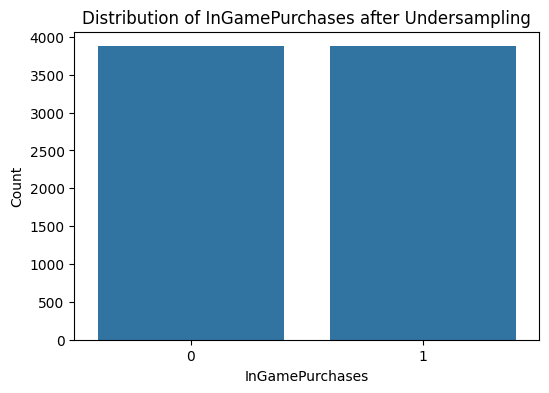

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of InGamePurchases after Undersampling')
plt.xlabel('InGamePurchases')
plt.ylabel('Count')
plt.show()


### Train Logistic Regression on Undersampled Data


In [22]:
lr_resampled_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)

# Evaluate the model using the undersampled training data and the original test data
evaluate_model("Logistic Regression (Undersampled)", lr_resampled_model, X_resampled, y_resampled, X_test, y_test)


=== Logistic Regression (Undersampled) Results (threshold = 0.50) ===
Accuracy: 0.4885

Class 0 (majority):
  Precision: 0.7933
  Recall:    0.4833
  F1-score:  0.6007

Class 1 (minority):
  Precision: 0.2016
  Recall:    0.5088
  F1-score:  0.2887

Macro F1: 0.4447


The results are basically identical to the original regression model, where we applied it on the unbalanced dataset.

## Overall Results and Conclusion

Across the models we tested, we can also observe some similar patterns:

*   Models generally performed well on the majority class, which is to be expected, because we are dealing with an imbalanced dataset.
*   Minority class performance was a point of struggle. The goal was to predict who are more prone to spending money on ingame purchases, meaning a good performance on the minority class is necessary.

Let's analyze them and provide visualizations.

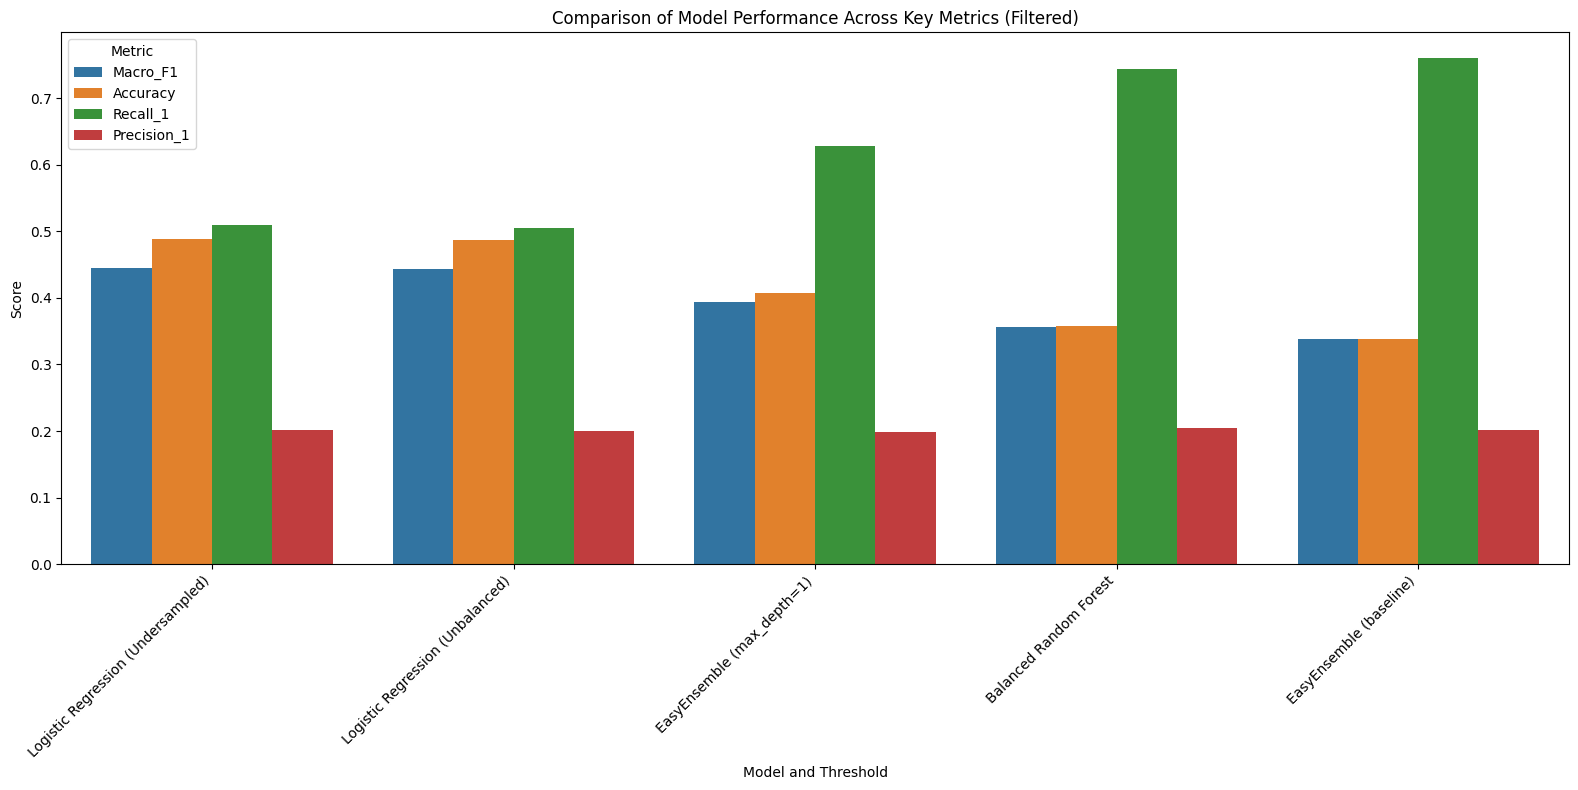

In [23]:
# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Filter out models that had issues with sampling_strategy
filtered_results_df = results_df[~results_df['Model'].isin([
    'EasyEnsemble (sampling=0.8)',
    'EasyEnsemble (sampling=0.7)'
])]

# Apply the user's new filtering request:
# For Balanced Random Forest and EasyEnsemble (baseline), keep only threshold 0.47
# For all other models, keep them as is (which will include default 0.5 threshold)

altered_threshold_models = ['Balanced Random Forest', 'EasyEnsemble (baseline)']

# Separate rows for altered_threshold_models with threshold != 0.47
exclude_condition = (
    filtered_results_df['Model'].isin(altered_threshold_models) &
    (filtered_results_df['Threshold'] != 0.47)
)

# Keep rows that do NOT meet the exclusion condition
results_to_plot_df = filtered_results_df[~exclude_condition]

# Sort by Macro_F1 for better visualization
results_df_sorted = results_to_plot_df.sort_values(by='Macro_F1', ascending=False)

# Select key metrics for plotting
metrics_to_plot = ['Macro_F1', 'Accuracy', 'Recall_1', 'Precision_1']

# Melt the DataFrame to long format for easier plotting
melted_results = results_df_sorted.melt(
    id_vars=['Model', 'Threshold'],
    value_vars=metrics_to_plot,
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(16, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=melted_results)
plt.title('Comparison of Model Performance Across Key Metrics (Filtered)')
plt.xlabel('Model and Threshold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

### Comparing Balanced Random Forest and EasyEnsemble at 0.47 Threshold

Comparing the **Balanced Random Forest** and EasyEnsemble (baseline) models, both with a 0.47 threshold:

*   Balanced Random Forest (Threshold 0.47):
    *   **Accuracy:** ~0.358
    *   **Macro F1:** ~0.356
    *   **Recall_1 (Minority Class):** ~0.743 (74.3% of actual buyers identified)
    *   **Precision_1 (Minority Class):** ~0.205 (20.5% of predicted buyers were actual buyers)

*   EasyEnsemble (baseline, Threshold 0.47):
    *   **Accuracy:** ~0.339
    *   **Macro F1:** ~0.338
    *   **Recall_1 (Minority Class):** ~0.761 (76.1% of actual buyers identified)
    *   **Precision_1 (Minority Class):** ~0.202 (20.2% of predicted buyers were actual buyers)

**Conclusion:**

The EasyEnsemble (baseline) at a 0.47 threshold has a slightly higher Recall_1 (76.1% vs 74.3%), meaning it's marginally better at identifying more of the actual in-game purchasers.

However, the Balanced Random Forest at a 0.47 threshold shows slightly better performance in terms of Accuracy, Macro F1, and Precision_1. This suggests that while EasyEnsemble might catch a tiny bit more buyers, the Balanced Random Forest is generally more balanced in its overall performance, making slightly fewer false positive predictions and achieving higher overall correctness.

Therefore, the Balanced Random Forest with a 0.47 threshold appears to be the better model if you are looking for a more stable and balanced performance across different metrics, even if its Recall_1 is fractionally lower than EasyEnsemble's.

Logistic Regression performed pretty much identically on both of the sets.

The core problem across all models is the very low precision for the minority class, consistently hovering around 20-21%, meaning the models when the model would predict a purchase, it would be correct only about 20% of the time. The tuned Balanced Random Forest did achieve high recall, but it came at a cost of lowering precision for the minority class.

### Confusion Matrix and Feature Importance charts for our best performing model which was the Balanced Random Forest with a threshhold of 0.47

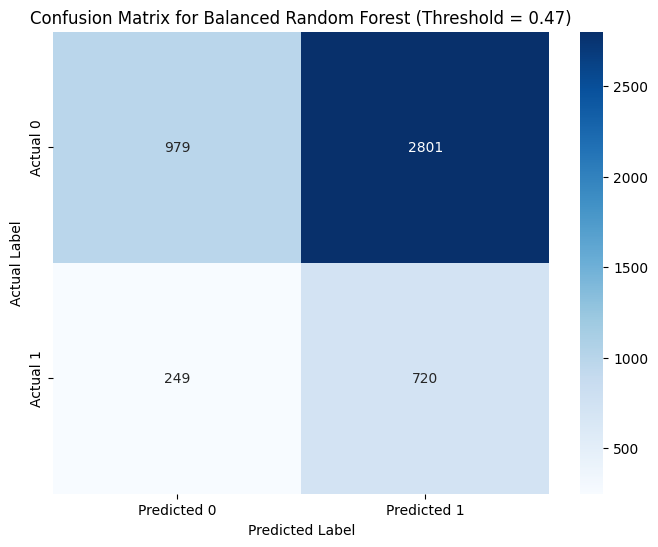

In [24]:
from sklearn.metrics import confusion_matrix

# Re-initialize and train the Balanced Random Forest model
brfc = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
brfc.fit(X_train, y_train)

# Make predictions with the 0.47 threshold
proba_1 = brfc.predict_proba(X_test)[:, 1]
y_pred_thr_047 = (proba_1 >= 0.47).astype(int)

cm = confusion_matrix(y_test, y_pred_thr_047)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Balanced Random Forest (Threshold = 0.47)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

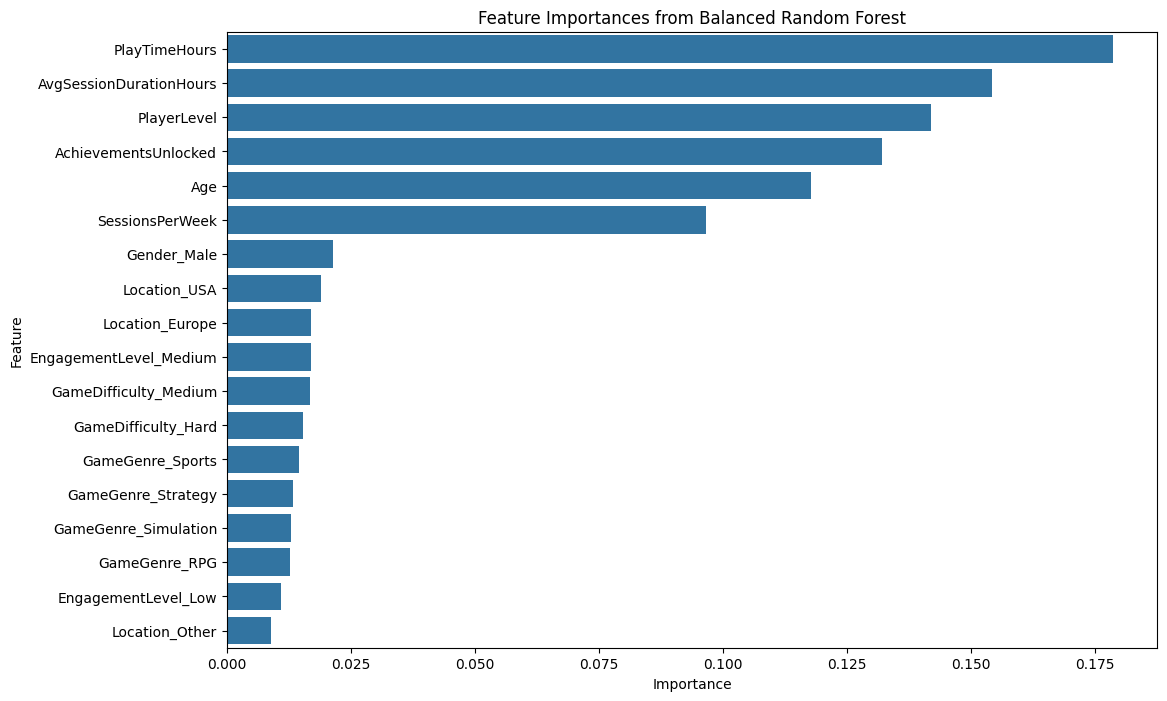

In [25]:
feature_importances = brfc.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Balanced Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### What the Feature Importance Graph Tells Us

This graph, 'Feature Importances from Balanced Random Forest', shows which features were most influential in the model's predictions. The longer the bar, the more important that feature was for the model. From this visualization, we can observe the following:

*   **PlayTimeHours**: This feature has the highest importance, suggesting that the amount of time a player spends in the game is the strongest indicator of whether they will make in-game purchases.
*   **PlayerLevel**: The player's level is also a highly significant predictor, indicating that more experienced or progressed players are more likely to engage in microtransactions.
*   **Age**: Age appears as the third most important feature, implying that certain age groups might be more prone to spending on in-game items. This could be interpreted as older people having more money to spend.
*   **AvgSessionDurationHours**: The average duration of a player's session also plays a notable role.

Conversely, features like `Location`, `GameGenre`, and `GameDifficulty` (especially their one-hot encoded versions) show less importance, suggesting they have a comparatively weaker influence on the prediction of in-game purchases in this model.

This analysis highlights that behavioral aspects (like playtime and player progression) are more critical drivers of in-game purchases than demographic or game-specific attributes for this dataset.

### Dataset might not be suitable
While do have the data whether or not the player made a purchase, we lack lots of micro details. We don't know how much they spent, how frequently etc. <br>
Dataset does lack behavioral patterns, for example does has the player even interacted with the ingame store or the social aspects of gaming, does the player prefer solo play or with a group. <br>
Demographic data is there, but again it's mostly very general.<br>
There isn't a lot of info about the game itself, is it free to play or paid. Is the game strictly singeplayer / multiplayer or both, this can have a big impact, because games do have different monetization strategies based on this feature. <br>

Overall we are trying to predict a very complex behavior, that has many varibles at play and we need more specific data, that provide triggers for such behavior occuring.